In [ ]:
import json
import re

from docx import Document


def parse_tick_field(text):
    """
    Given a string that uses tick markers "☒" and "☐",
    returns a dict with "options" (list of options)
    and "selected" (list of options marked with ☒).
    Example: "☒ Female\t\t☐ Male" becomes:
      {"options": ["Female", "Male"], "selected": ["Female"]}
    """
    # This regular expression matches a tick marker followed by text until the next tick marker (if any)
    pattern = r"(☒|☐)\s*([^☒☐]+)"
    matches = re.findall(pattern, text)
    options = []
    selected = []
    for mark, option in matches:
        option = option.strip()
        options.append(option)
        if mark == "☒":
            selected.append(option)
    return {"options": options, "selected": selected}


def clean_text(text):
    """
    Clean extra spaces, newlines, and tab characters.
    """
    return " ".join(text.replace("\t", " ").split())


def parse_docx_to_json(doc):
    """
    Takes a python-docx Document and parses its tables into meaningful JSON.

    Heuristics:
      - A table with one row and one cell (non-empty) is used as a section header.
      - Other tables are assumed to contain key/value fields.
      - If a cell's text includes tick characters, we parse that cell to return both
        the available options and the ones selected.
      - If the same key appears multiple times within a section, the values are grouped in a list.
    """
    result = {}
    current_section = "Default"  # fallback if no header is found yet
    result[current_section] = {}

    for table in doc.tables:
        # Convert table rows into lists of cleaned cell text
        table_data = []
        for row in table.rows:
            row_values = [clean_text(cell.text) for cell in row.cells]
            # Only add row if at least one cell is non-empty
            if any(row_values):
                table_data.append(row_values)

        # Heuristic: if this table is a single-cell header table
        if len(table_data) == 1 and len(table_data[0]) == 1:
            section_title = table_data[0][0]
            if section_title:
                current_section = section_title
                result[current_section] = {}
            continue

        # Otherwise, we treat this table as data for the current section.
        for row in table_data:
            # Assume the first cell is the key.
            key = row[0] if row[0] else None
            if not key:
                continue  # skip if no key

            # For the value, look through the remaining cells for non-empty content.
            # (Sometimes there might be multiple pieces of information.)
            value_candidates = [cell for cell in row[1:] if cell]
            if not value_candidates:
                value = None
            elif len(value_candidates) == 1:
                value = value_candidates[0]
            else:
                value = value_candidates

            # Check if this value appears to be a tick field.
            if value and isinstance(value, str) and ("☒" in value or "☐" in value):
                value = parse_tick_field(value)
            elif isinstance(value, list):
                # For lists, check if any element is a tick field.
                new_vals = []
                for v in value:
                    if "☒" in v or "☐" in v:
                        new_vals.append(parse_tick_field(v))
                    else:
                        new_vals.append(v)
                value = new_vals

            # If the key already exists, merge values in a list.
            if key in result[current_section]:
                # Convert the existing value into a list if it’s not already one.
                if not isinstance(result[current_section][key], list):
                    result[current_section][key] = [result[current_section][key]]
                result[current_section][key].append(value)
            else:
                result[current_section][key] = value

    return result

In [ ]:
import os
import zipfile


def locate_profile(client_number: int) -> Document:
    """
    Given a client number, locate and return the Document() instance
    for the corresponding profile inside the appropriate zip archive.
    Assumes each zip contains a file named profile.docx.

    The archives are arranged in a cycle of 500 clients divided into
    three segments: the first 200 clients, the next 200, and then the final 100.
    For example:
      - Clients 1-200   -> folder "client_001_200"
      - Clients 201-400 -> folder "client_201_400"
      - Clients 401-500 -> folder "client_401_500"
      - Clients 501-700 -> folder "client_501_700"
      - Clients 701-900 -> folder "client_701_900"
      - Clients 901-1000-> folder "client_901_1000"
      ... and so on.
    """
    if client_number < 1:
        raise ValueError("Client number must be a positive integer.")

    # Determine the cycle of 500 in which the client resides.
    cycle = (client_number - 1) // 500  # 0-indexed cycle
    offset = (client_number - 1) % 500 + 1  # position within the current cycle (1 to 500)

    # Determine the bucket (segment) within the 500-client cycle.
    if offset <= 200:
        bucket_start = cycle * 500 + 1
        bucket_end = cycle * 500 + 200
    elif offset <= 400:
        bucket_start = cycle * 500 + 201
        bucket_end = cycle * 500 + 400
    else:
        bucket_start = cycle * 500 + 401
        bucket_end = cycle * 500 + 500

    # Format the folder name with zero-padding.
    folder = f"client_{str(bucket_start).zfill(3)}_{str(bucket_end).zfill(3)}"

    # Construct the zip file name. (The zip file name is not zero-padded.)
    zip_filename = f"client_{client_number}.zip"
    zip_path = os.path.join("data", folder, zip_filename)

    # Check that the zip archive exists.
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Could not find zip file: {zip_path}")

    # Open the zip archive and load the profile document.
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        if "profile.docx" not in zip_ref.namelist():
            raise FileNotFoundError("profile.docx not found in the zip archive.")
        with zip_ref.open("profile.docx") as docx_file:
            return Document(docx_file)


In [5]:
doc = locate_profile(900)
parsed_data = parse_docx_to_json(doc)
print(json.dumps(parsed_data, indent=2, ensure_ascii=False))

{
  "Default": {},
  "Client Information": {
    "Last Name": "Schneider",
    "First/ Middle Name (s)": "Simon Julian",
    "Address": "Deák Ferenc tér 44, 534 40 Győr",
    "Country of Domicile": "Hungary",
    "Date of birth": "1956-07-09",
    "Nationality": "German",
    "Passport No/ Unique ID": "ZE3638628",
    "ID Type": "passport",
    "ID Issue Date": "2018-03-24",
    "ID Expiry Date": "2028-03-23",
    "Gender": {
      "options": [
        "Female",
        "Male"
      ],
      "selected": [
        "Male"
      ]
    }
  },
  "Account Holder – Contact Management and Services – Contact Info": {
    "Communication Medium": "Telephone +36 38 496 1433"
  },
  "Account Holder – Personal Info": {
    "Is the client or associated person a Politically Exposed Person as defined in the Client Acceptance Policy?": [
      {
        "options": [
          "No",
          "Yes"
        ],
        "selected": [
          "No"
        ]
      },
      "If ‘Yes’, please complete the App

In [1]:
import cv2
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

passport_image_path = "/Users/shyngys/personal/data-workspace/data/client_001_200/client_1/passport.png"


"""
Perform OCR on a passport image using docTR and return the recognized text blocks.
"""

# 3. Load a pre-trained OCR model (both detection & recognition)
#    By default, docTR uses a DB (Differentiable Binarization) text detector
#    and a CRNN recognition model. Many other combos exist too (e.g., DB + SAR).
ocr_model = ocr_predictor(
    det_arch="db_resnet50",  # text detection backbone
    reco_arch="crnn_vgg16_bn",  # text recognition backbone
    pretrained=True,
)

# 4. Perform OCR on the image
#    DocumentFile.from_images expects images as either file paths or PIL images,
#    but docTR 0.5+ also supports np.ndarray in shape (H, W, C).
doc = DocumentFile.from_images([passport_image_path])
result = ocr_model(doc)

# 5. Extract the text blocks from the OCR result
#    result.pages is a list of pages, each containing blocks, lines, and words.
#    For a single-page passport photo, you likely have just `result.pages[0]`.
recognized_text = []
for page_idx, page in enumerate(result.pages):
    for block_idx, block in enumerate(page.blocks):
        block_text = " ".join([line.content for line in block.lines])
        recognized_text.append(block_text)


for idx, text in enumerate(recognized_text):
    print(f"Block {idx}: {text}")

/Users/shyngys/personal/data-workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'Line' object has no attribute 'content'

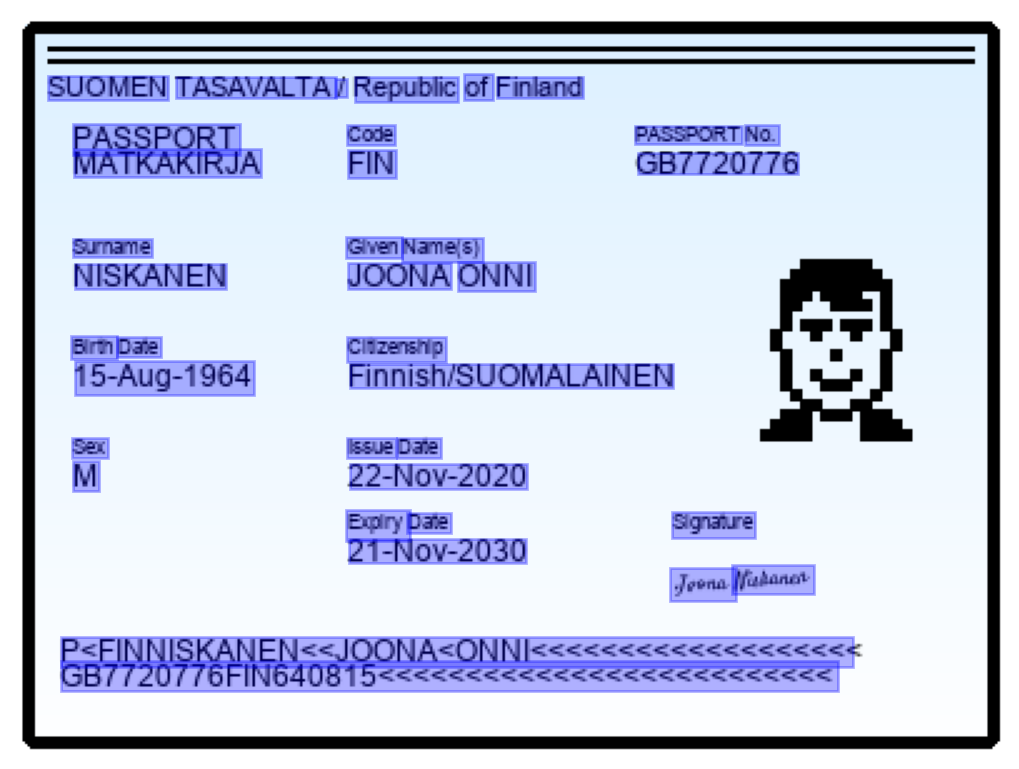

In [2]:
result.show()

In [62]:
import copy

import requests
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

%matplotlib inline  

model_id = "microsoft/Florence-2-large-ft"
model = (
    AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.float32).eval().to("cpu")
)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

    return parsed_answer


A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [63]:
image = Image.open(passport_image_path)
task_prompt = "<OCR>"
run_example(image, task_prompt)

{'<OCR>': 'SUOMEN TASAVALTA / Republic of FinlandPASSPORTCodeMATKAKIRJAFINPASPORT No.GB7720776SurnameGiven Name(s)NISKANENJOONA ONNIBirth DateCitizenship15-Aug-1964Finnish/SUOMALAINENSexIssue DateM22-Nov-2020Expliry Date21- Nov-2030SignatureJoona NuhanorP<FINNISHANEN<JOONA<ONNI <<<<<<<<<GB777207776FIN640815 <<<<<<<<<'}

In [64]:
task_prompt = "<OCR_WITH_REGION>"
results = run_example(image, task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[14.600000381469727, 25.05000114440918, 229.40000915527344, 25.05000114440918, 229.40000915527344, 36.75, 14.600000381469727, 36.75], [24.200000762939453, 45.45000076293945, 91.0, 45.45000076293945, 91.0, 56.250003814697266, 24.200000762939453, 56.250003814697266], [134.1999969482422, 45.75, 153.8000030517578, 45.75, 153.8000030517578, 53.85000228881836, 134.1999969482422, 53.85000228881836], [24.200000762939453, 55.650001525878906, 100.5999984741211, 55.650001525878906, 100.5999984741211, 66.75, 24.200000762939453, 66.75], [134.1999969482422, 55.650001525878906, 153.8000030517578, 55.650001525878906, 153.8000030517578, 66.45000457763672, 134.1999969482422, 66.45000457763672], [248.60000610351562, 45.45000076293945, 306.20001220703125, 45.45000076293945, 306.20001220703125, 53.85000228881836, 248.60000610351562, 53.85000228881836], [249.40000915527344, 55.35000228881836, 316.20001220703125, 55.35000228881836, 316.20001220703125, 66.75, 249.40000915

In [ ]:
result.pages[0].blocks[0].lines[1]

Line(
  (words): [Word(value='PASSPORT', confidence=0.51)]
)

In [17]:
result.pages[0].blocks[0].lines[5]

Line(
  (words): [Word(value='FIN', confidence=0.99)]
)

In [55]:
for line in result.pages[0].blocks[0].lines:
    print(line)

Line(
  (words): [
    Word(value='SUOMEN', confidence=1.0),
    Word(value='TASAVALIA', confidence=0.77),
    Word(value='/', confidence=0.99),
    Word(value='epublic', confidence=0.91),
    Word(value='of', confidence=1.0),
    Word(value='Finland', confidence=0.98),
  ]
)
Line(
  (words): [Word(value='PASSPORT', confidence=0.51)]
)
Line(
  (words): [Word(value='Code', confidence=1.0)]
)
Line(
  (words): [
    Word(value='PASSPORT', confidence=1.0),
    Word(value='No.', confidence=1.0),
  ]
)
Line(
  (words): [Word(value='MATKAKIRJA', confidence=1.0)]
)
Line(
  (words): [Word(value='FIN', confidence=0.99)]
)
Line(
  (words): [Word(value='GB//20//6', confidence=0.63)]
)
Line(
  (words): [Word(value='sumame', confidence=0.56)]
)
Line(
  (words): [
    Word(value='Given', confidence=0.9),
    Word(value='Name(s)', confidence=0.7),
  ]
)
Line(
  (words): [Word(value='NISKANEN', confidence=0.99)]
)
Line(
  (words): [
    Word(value='JOONA', confidence=1.0),
    Word(value='ONNI', confid

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

# model_name = "OpenGVLab/InternVL2_5-1B"  # or "InternVL2_5-2B", "InternVL2_5-4B", etc.
# # Load the model (CPU device by default). Use low_cpu_mem_usage to reduce RAM during loading.
# model = AutoModel.from_pretrained(
#     model_name,
#     low_cpu_mem_usage=True,
#     torch_dtype=torch.float16,  # load in half precision to save memory
#     trust_remote_code=True,  # required for custom model code
# ).eval()  # .eval() to set no-grad, not training
# # (Note: omit use_flash_attn and .cuda() since we're on CPU.)

model_name = "OpenGVLab/InternVL2_5-1B"  # or any available variant suited for CPU.
model = AutoModel.from_pretrained(
    model_name,
    low_cpu_mem_usage=False,
    trust_remote_code=True,
    torch_dtype=torch.float32,
).eval()  # Make sure the model is in eval mode.

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# tokenizer = AutoTokenizer.from_pretrained(
#     model_name,
#     use_fast=False,  # use the Python tokenizer (fast might not be supported)
#     trust_remote_code=True,
# )


In [71]:
from PIL import Image
from torchvision import transforms

image = Image.open(passport_image_path)

# Define the same normalization as used in training
transform = transforms.Compose(
    [
        transforms.Resize((448, 448)),  # resize to 448x448
        transforms.ToTensor(),  # convert to tensor [0,1]
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

# Load and preprocess the image
image_tensor = transform(image)  # shape: [3, 448, 448]
# InternVL expects a batch of images (or image patches). Add batch dimension:
pixel_values = image_tensor.unsqueeze(0)  # shape: [1, 3, 448, 448]

In [ ]:
# Prepare a prompt asking the model to extract text
prompt = (
    "<image>\n"
    "Extract all text from the passport image and output the result as a valid JSON object with exactly the following keys:\n"
    "  - Surname\n"
    "  - Code\n"
    "  - Passport Number\n"
    "  - Given Name\n"
    "  - Birth Date\n"
    "  - Citizenship\n"
    "  - Sex\n"
    "  - Issue Date\n"
    "  - Expiry Date\n\n"
    "If any field is missing, set its value to an empty string. Do not include any additional text, comments, or formatting. Output only the JSON object, with no extra characters (e.g. do not output a header like 'json' or any markdown code fences)."
)
# Generate a response from the model
# (We use a generation config with a limit on tokens; adjust as needed)
output = model.chat(tokenizer, pixel_values, prompt, generation_config={"max_new_tokens": 256, "do_sample": False})
print(output)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


```json
{
  "Surname": "NISKANEN",
  "Code": "FIN",
  "Passport Number": "GB7720776",
  "Given Name": "JOONA ONNI",
  "Birth Date": "15-Aug-1964",
  "Citizenship": "Finnish/SUOMALAINEN",
  "Sex": "M",
  "Issue Date": "22-Nov-2020",
  "Expiry Date": "21-Nov-2030"
}
```


In [ ]:
import json

json.loads(output)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)